<a href="https://colab.research.google.com/github/ardrkha/trash-classification/blob/main/trash_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trash Classification Model with CNN

## 1. Approach Explanation

In this project, I aim to build a CNN model to classify trash images into specific categories. The CNN model is trained on the "TrashNet" dataset.
- **Justification**: CNNs are well-suited for image classification tasks as they can capture spatial hierarchies in images.
- **Pros**: Overall, the model experienced a significant increase in training accuracy. The training and validation accuracy results were also not much different, indicating that the model did not experience overfitting or underfitting.
- **Cons**: Only using accuracy and confusion matrix as an evaluation metric.
- **Steps**:
 - Load and prepare the dataset.
 - Visualize and analyze the data distribution.
 - Create and train the CNN model.
 - Evaluate the model and discuss any model bias or dataset issues.


## 2. Data Preparation

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00


In [2]:
!pip install wandb

In [3]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
from datasets import load_dataset
from PIL import Image
from collections import Counter
import random
import seaborn as sns
import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hardatama27 (ardrkha) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# Load the dataset
ds = load_dataset("garythung/trashnet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [6]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


In [7]:
# Load dataset from Hugging Face
ds = load_dataset("garythung/trashnet")

# The main path for storing datasets
base_path = "/content/datasets"

# Create a main folder if it doesn't exist yet
os.makedirs(base_path, exist_ok=True)

# Get a list of class names from a dataset
class_names = ds['train'].features['label'].names

# Create a folder for each class
for class_name in class_names:
    os.makedirs(os.path.join(base_path, class_name), exist_ok=True)

print("Folders for each class have been successfully created!")

Folders for each class have been successfully created!


In [8]:
# Function to save images according to their class
def save_images(dataset):
    for idx, sample in enumerate(dataset):
        image = sample['image']  # Take the image
        label = sample['label']  # Take the label

        # Convert numeric labels to class names
        class_name = class_names[label]

        # Image storage path
        image_path = os.path.join(base_path, class_name, f"{idx}.jpg")

        # Save the image
        image.save(image_path)

# Save all images into a folder
save_images(ds['train'])

print("All images have been moved to folders according to their class!")

All images have been moved to folders according to their class!


## 3. Exploratory Image Analysis

In [9]:
image_size = 224
channels = 3
batch_size = 32
epochs = 50

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/datasets',
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)
class_names = dataset.class_names
print(class_names)

Found 5054 files belonging to 6 classes.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [11]:
total_samples = 0
class_counts = {}

for images, labels in dataset:
  total_samples += images.shape[0]
  for label in labels.numpy():
    class_name = class_names[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

print("Total data:", total_samples)
print("\nData per class:")
for class_name, count in class_counts.items():
  print(f"Total image of the class {class_name}: {count}")

Total data: 5054

Data per class:
Total image of the class metal: 820
Total image of the class plastic: 964
Total image of the class cardboard: 806
Total image of the class paper: 1188
Total image of the class glass: 1002
Total image of the class trash: 274


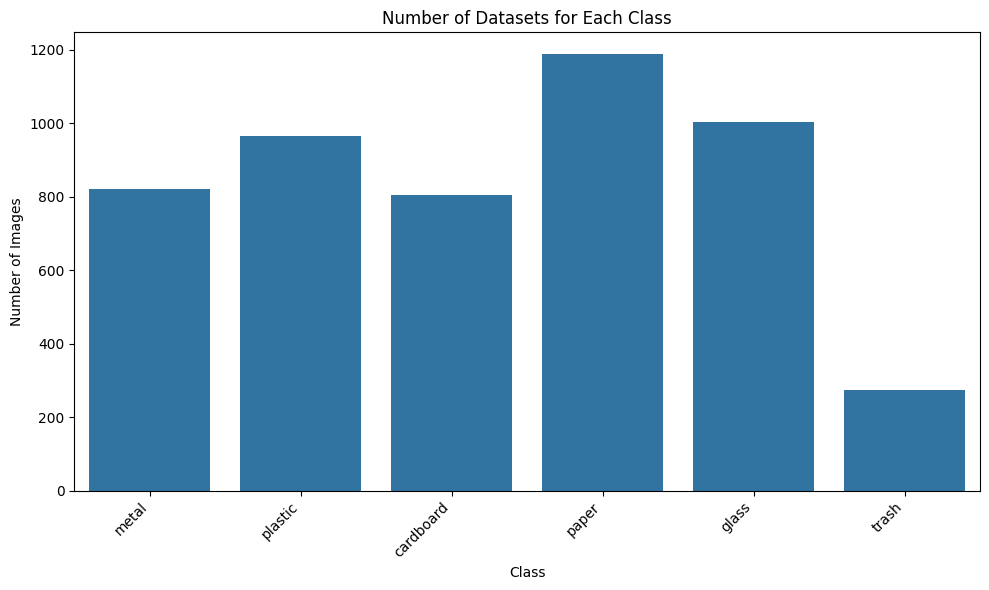

In [12]:
# Visualize the number of images for each class

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Number of Datasets for Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Class: cardboard


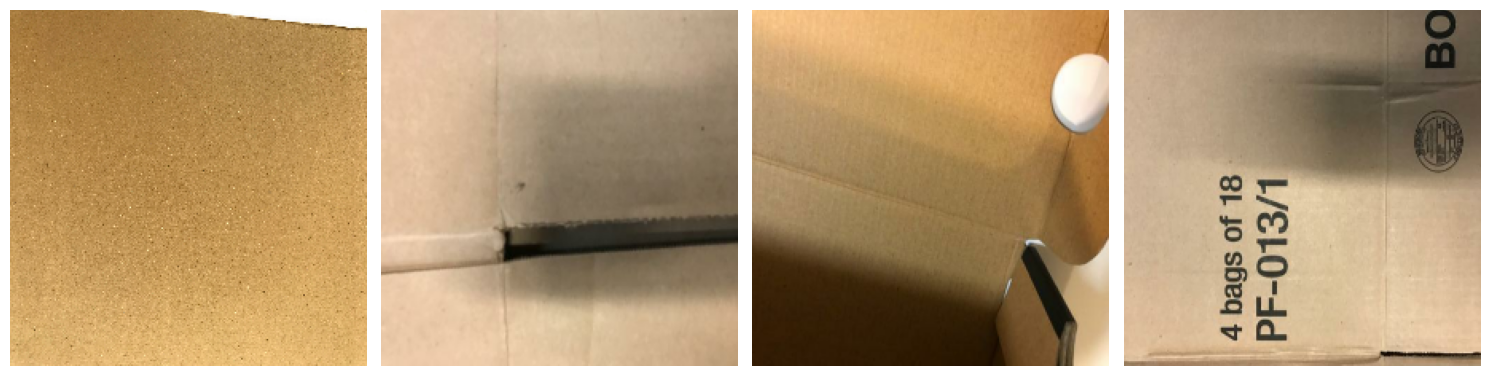

Class: glass


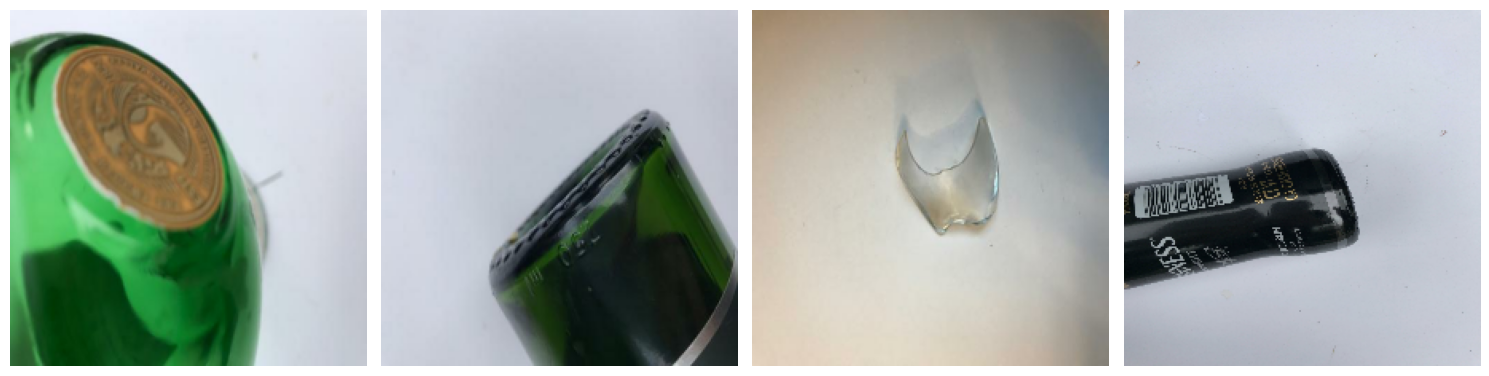

Class: metal


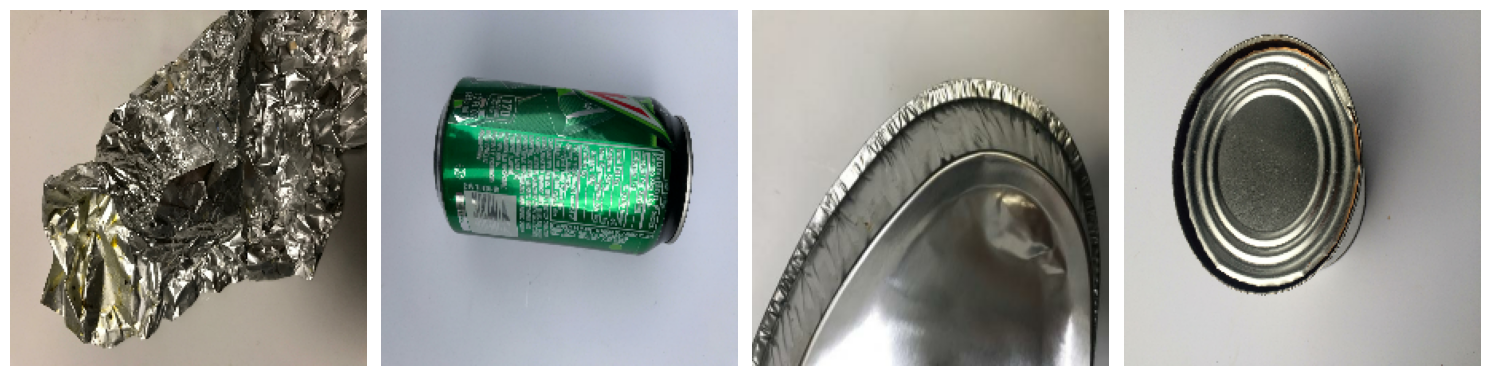

Class: paper


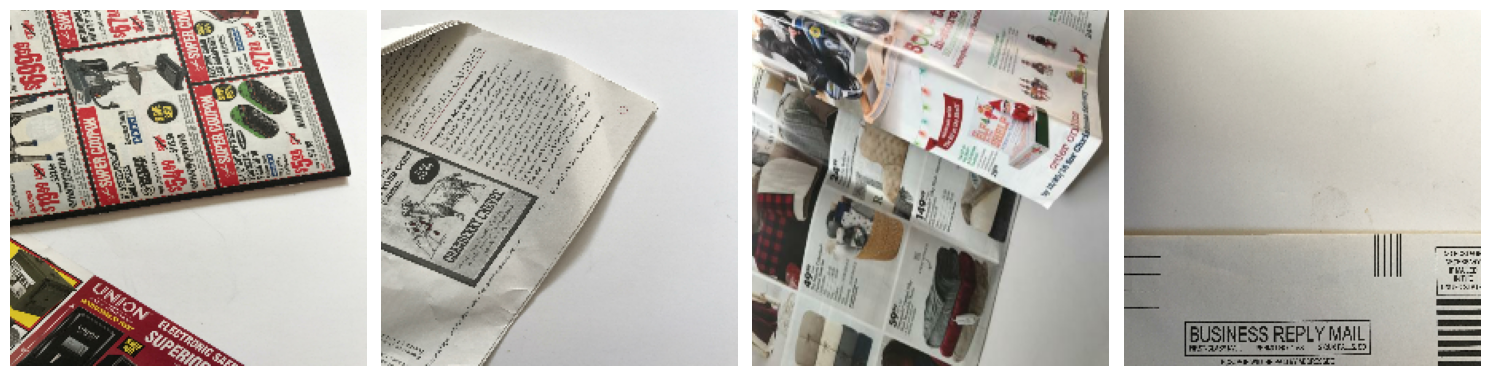

Class: plastic


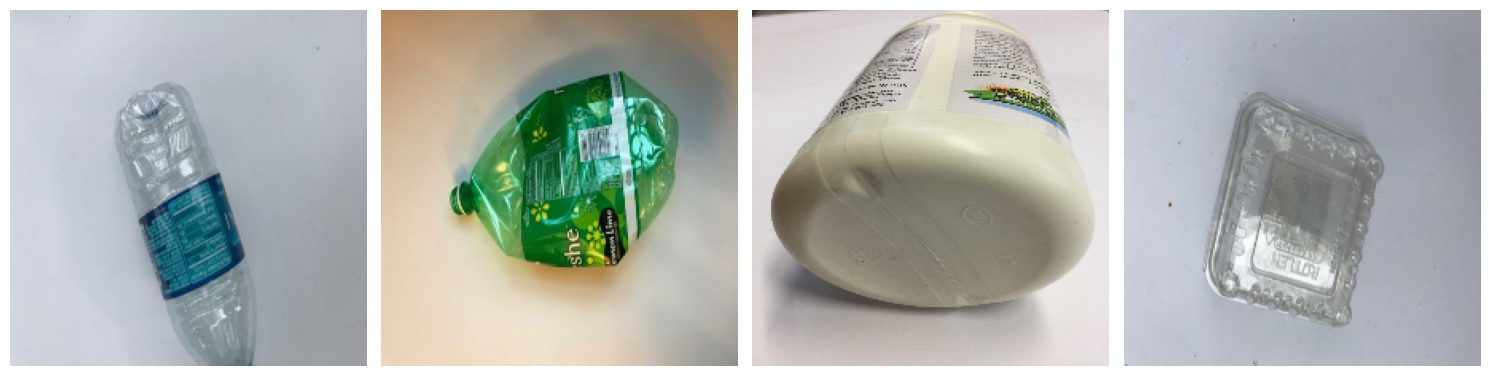

Class: trash


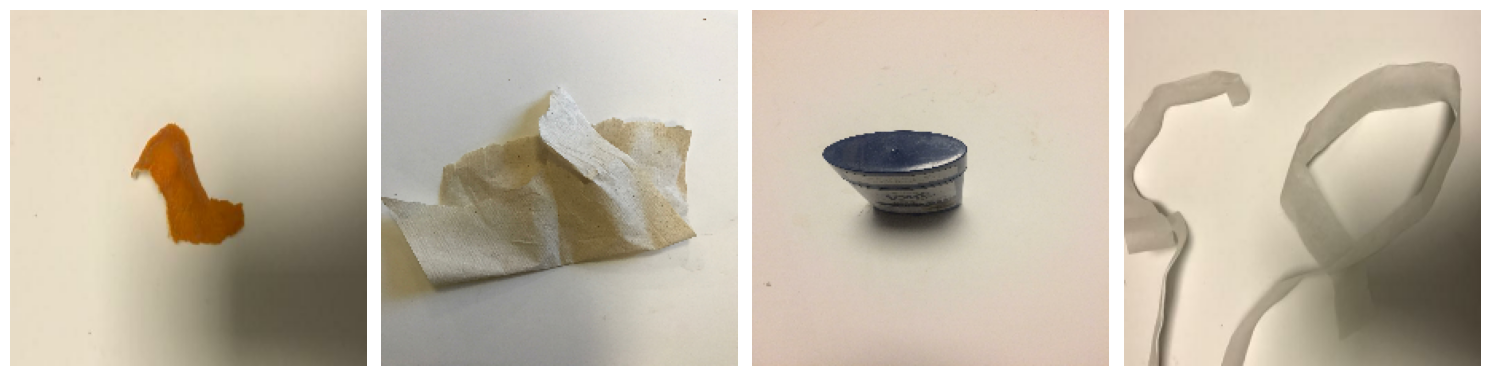

In [13]:
# Visualize datasets

def visualize_images(dataset, class_names):
  for class_name in class_names:
    print(f"Class: {class_name}")
    count = 0
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    for images, labels in dataset:
      for i in range(images.shape[0]):
          if class_names[labels[i]] == class_name and count < 4:
              axes.ravel()[count].imshow(images[i].numpy().astype("uint8"))
              axes.ravel()[count].axis("off")
              count += 1
          if count == 4:
              break
      if count == 4:
          break
    plt.tight_layout()
    plt.show()

visualize_images(dataset, class_names)

## 4. Preprocessing Data

In [14]:
# Split the dataset into Train, Validation, Test

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_dataset = ds.take(train_size)
  val_dataset = ds.skip(train_size).take(val_size)
  test_dataset = ds.skip(train_size).skip(val_size)

  return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [15]:
print("Batch Amount: ", len(dataset))
print("Batch Number for Train: ", len(train_dataset))
print("Batch Number for Validation: ", len(val_dataset))
print("Batch Number for Test: ", len(test_dataset))

Batch Amount:  158
Batch Number for Train:  126
Batch Number for Validation:  15
Batch Number for Test:  17


In [16]:
for features, labels in dataset.take(1):
    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)

Features shape: (32, 224, 224, 3)
Labels shape: (32,)


In [17]:
# Convert to one hot encoding

num_classes = 6

def one_hot_encode(features, labels):
    labels = tf.one_hot(labels, depth=num_classes)
    return features, labels

train_dataset = train_dataset.map(one_hot_encode)
val_dataset = val_dataset.map(one_hot_encode)
test_dataset = test_dataset.map(one_hot_encode)


In [18]:
# Cache, Shuffle, Prefetch

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# Normalization

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1./255)
])

In [20]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
], name="data_augmentation")


In [21]:
# Apply normalization and data augmentation

train_dataset = train_dataset.map(lambda x, y: (resize_and_rescale(x), y))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
val_dataset = val_dataset.map(lambda x, y: (resize_and_rescale(x), y))
test_dataset = test_dataset.map(lambda x, y: (resize_and_rescale(x), y))

## 4. Model Training & Evaluation Analysis

In [22]:
# Load the ResNet50 model without the last fully connected layer.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, channels))

# Freeze the initial layer so that it does not update during initial training (fine-tuning later)
for layer in base_model.layers:
    layer.trainable = False

# Add a new layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(6, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Print architectural models
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# Initialize wandb with configuration
wandb.init(
    project="trash_classification (update)",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "image_size": (224, 224),
        "model_architecture": "CNN"
    }
)

# Custom Callback for logging metrics to wandb
class WandbLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Log training and validation metrics at the end of each epoch
        wandb.log({
            'epoch': epoch,
            'loss': logs['loss'],
            'accuracy': logs['accuracy'],
            'val_loss': logs['val_loss'],
            'val_accuracy': logs['val_accuracy']
        })

In [25]:
# Callback to stop training if there is no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
# Training the model

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=batch_size,
    verbose=1,
    epochs=epochs,
    callbacks=([WandbLoggingCallback()], early_stopping)
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.5777 - loss: 1.1535 - val_accuracy: 0.8042 - val_loss: 0.5499
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 288ms/step - accuracy: 0.7913 - loss: 0.5683 - val_accuracy: 0.8292 - val_loss: 0.4598
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 291ms/step - accuracy: 0.8092 - loss: 0.5092 - val_accuracy: 0.8479 - val_loss: 0.4191
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 286ms/step - accuracy: 0.8485 - loss: 0.4086 - val_accuracy: 0.8792 - val_loss: 0.3313
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.8545 - loss: 0.3919 - val_accuracy: 0.8813 - val_loss: 0.3480
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 306ms/step - accuracy: 0.8851 - loss: 0.3333 - val_accuracy: 0.9125 - val_loss: 0.2847
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 283ms/step - accuracy: 0.8736 - loss: 0.3531 - val_accuracy: 0.8854 - val_loss: 0.2976
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 278ms/step - accuracy: 0.8987 - loss: 0.2

In [27]:
# Evaluating the model on the test data

loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 95s 42ms/step - accuracy: 0.9847 - loss: 0.0529
Loss: 0.07930674403905869
Accuracy: 0.970588207244873


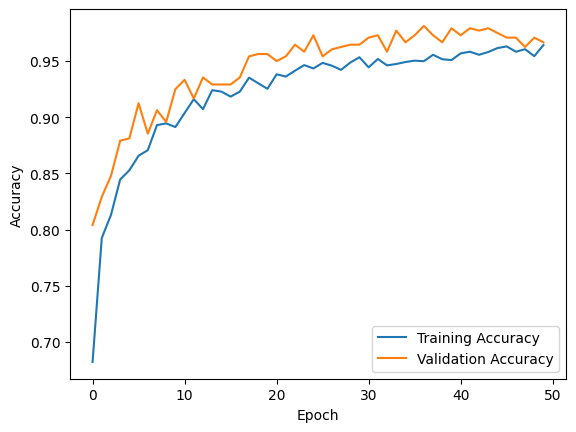

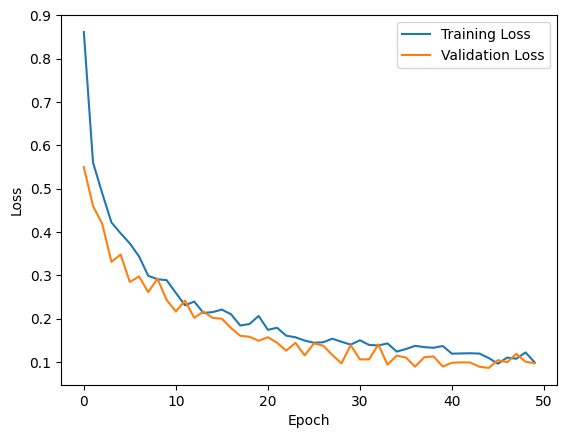

In [28]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


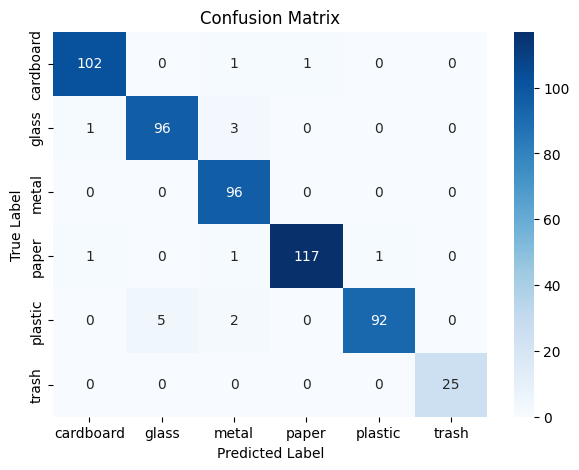

In [29]:
# Confusion Matrix

y_true = []
y_pred = []

for images, labels in test_dataset:
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis = 1)
  true_labels = np.argmax(labels.numpy(), axis = 1)
  y_true.extend(true_labels)
  y_pred.extend(predicted_labels)

confusion_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize= (7,5))
sns.heatmap(confusion_matrix, annot=True, fmt="d",
cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━

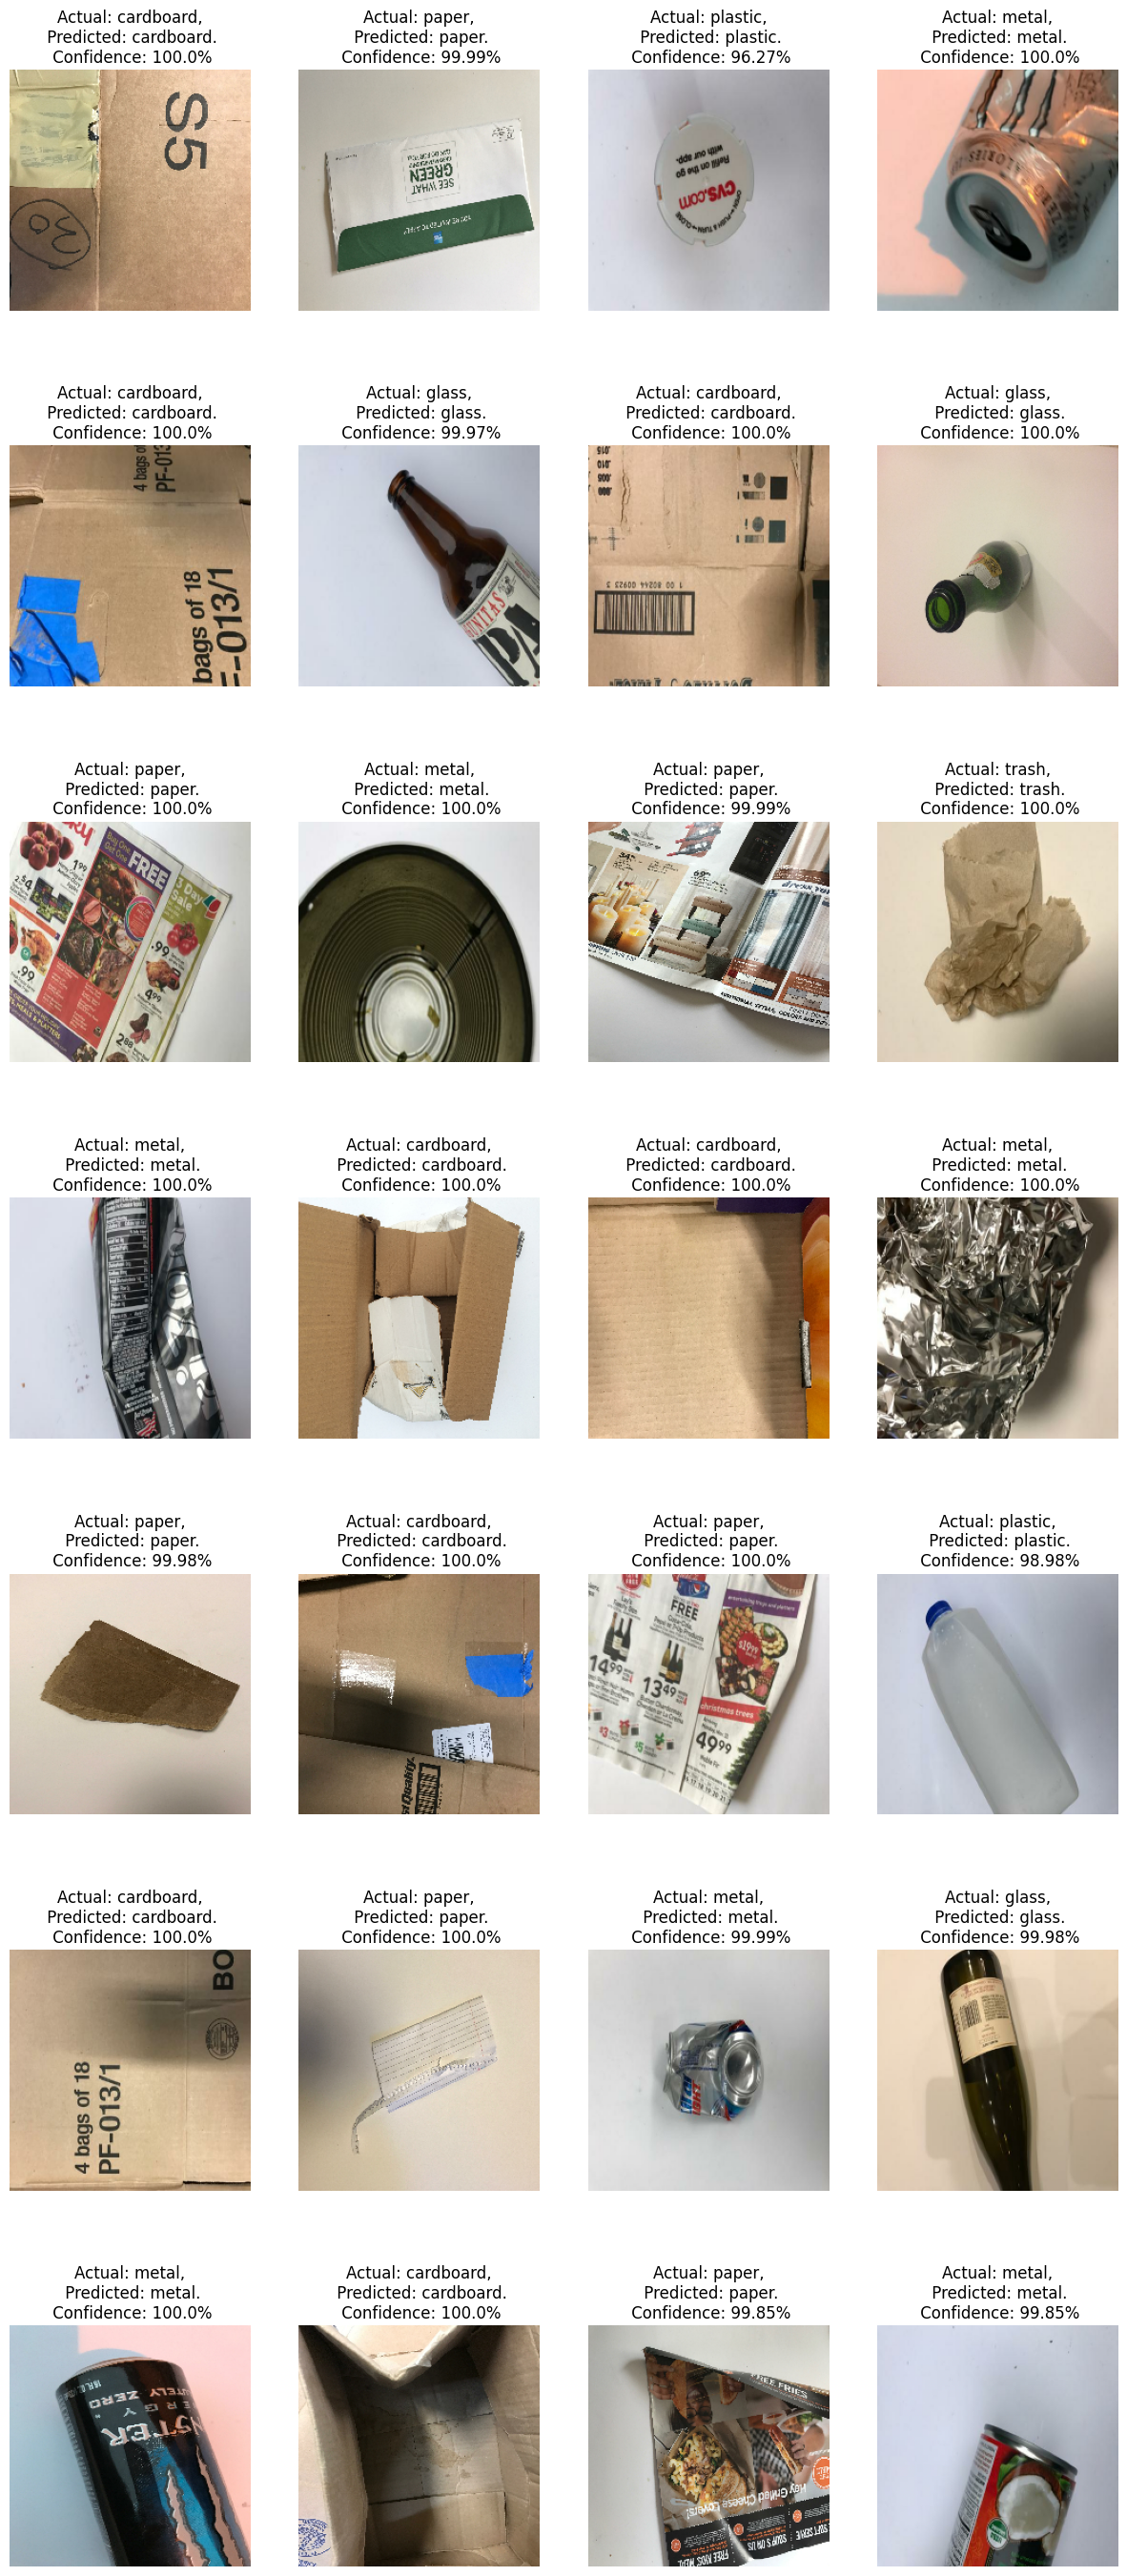

In [30]:
# Visualize Prediction

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 35))
for images, labels in test_dataset.take(1):
    for i in range(28):
        ax = plt.subplot(7, 4, i + 1)
        plt.imshow(tf.cast(images[i] * 255.0, tf.uint8).numpy())

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[np.argmax(labels[i].numpy())]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [31]:
# Saving the trained model

model.save('trash_classification_model.h5')

## 5. Additional Insights

The model shows varying levels of accuracy for each class, possibly due to class imbalance or challenging visual distinctions.
- **Model Bias**: The *‘trash’* class has less data than the other five data classes. This may lead to a bias where the model has a harder time classifying *‘trash’* images than other classes.
- **Dataset Issues**: The dataset's image quality, variation, and potential class imbalance could be factors affecting model performance. Further analysis and data augmentation could mitigate these issues.